# 🚀 Part 2: Model Training

## Mục tiêu
1. Load dữ liệu đã xử lý (train set)
2. Feature scaling với weight tuning
3. Tìm số clusters tối ưu (k)
4. Train K-Means model
5. Lưu model và scaler

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Processed Data

In [28]:
# Load data
PROCESSED_DIR = '../data/processed'

# Load metadata
with open(f'{PROCESSED_DIR}/metadata.json', 'r') as f:
    metadata = json.load(f)

print("📋 METADATA:")
print(json.dumps(metadata, indent=2))

# Load train data
df_train = pd.read_csv(f'{PROCESSED_DIR}/train_data.csv')
X_train = np.load(f'{PROCESSED_DIR}/X_train.npy')

print(f"\n📊 Loaded training data:")
print(f"   DataFrame shape: {df_train.shape}")
print(f"   Features shape: {X_train.shape}")
print(f"   Features: {metadata['feature_columns']}")

📋 METADATA:
{
  "total_samples": 471,
  "train_samples": 376,
  "test_samples": 95,
  "train_ratio": 0.8,
  "test_ratio": 0.2,
  "random_seed": 42,
  "feature_columns": [
    "pickup_coordinates_lat",
    "pickup_coordinates_lng",
    "departure_time_minutes"
  ],
  "direction": "Hanoi_to_QuangNinh",
  "processed_date": "2026-01-08T21:25:34.415187",
  "date_range": {
    "min": "01/01/2026",
    "max": "31/12/2025"
  }
}

📊 Loaded training data:
   DataFrame shape: (376, 22)
   Features shape: (376, 3)
   Features: ['pickup_coordinates_lat', 'pickup_coordinates_lng', 'departure_time_minutes']


In [29]:
# Quick view of train data
print("📊 Training data sample:")
df_train[['client_id', 'pickup', 'destination', 'departureTime', 
          'pickup_coordinates_lat', 'pickup_coordinates_lng', 
          'departure_time_minutes']].head(10)

📊 Training data sample:


,client_id,pickup,destination,departureTime,pickup_coordinates_lat,pickup_coordinates_lng,departure_time_minutes
0,1VSbGmFH4i33RPGgkM8DWVAty8rV,Hanoi - Giap Bat Station,Van Don Ferry Terminal,15:15,20.916261,105.663986,915
1,fBXQQaXaKuzwDDHGBm5eWQChAzv1,Hanoi - Long Bien Station,Ha Long - Bai Chay Station,04:45,21.104374,105.540806,285
2,z96TQRrZEcXmZCp6msckB0GWSPGa,Hanoi - Gia Lam Station,Ha Long - Tuan Chau Port,04:00,20.773481,105.613309,240
3,4EUWLSSEAc6880ScADGRBVHGumn5,Hanoi - Gia Lam Station,Ha Long - Bai Chay Station,08:15,21.017578,105.923167,495
4,QRi2TPA1X52ow1AvdH9qJK2eZWQ6,Hanoi - Luong Yen Station,Ha Long - Bai Chay Station,11:45,20.772734,105.785287,705
5,ppG9UhBtbg3XWSk8WDdbQ3XGbhc1,Hanoi - Giap Bat Station,Ha Long - Bai Chay Station,13:15,20.746866,105.585774,795
6,0bYyoVdBWYF3riQDB5rCeEV3aW6Z,Hanoi - Long Bien Station,Cam Pha Bus Station,11:15,20.989818,105.863768,675
7,CYCM6vqh3r3xf9ZeVikgkFCvEAiG,Hanoi - My Dinh Bus Station,Ha Long - Tuan Chau Port,05:00,20.957368,105.798789,300
8,QGTN3ou53ZTxbzHiDxezYaekH9hK,Hanoi - Long Bien Station,Ha Long - Tuan Chau Port,14:45,20.812434,105.887002,885
9,5iEy78NNhD4Jhu6GicHZm6HJ3o67,Hanoi - Luong Yen Station,Ha Long - Tuan Chau Port,22:00,21.138275,105.789712,1320


## 2. Feature Scaling with Weights

### Trọng số features:
- **coord_weight**: Trọng số cho tọa độ (lat, lng)
- **time_weight**: Trọng số cho thời gian khởi hành

**Khuyến nghị**: `coord_weight=1.0`, `time_weight=0.5` (ưu tiên vị trí hơn thời gian)

In [30]:
# Set feature weights
COORD_WEIGHT = 1.0  # Weight for geographic coordinates
TIME_WEIGHT = 0.5   # Weight for departure time

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply weights
X_train_weighted = X_train_scaled.copy()
X_train_weighted[:, 0] *= COORD_WEIGHT  # lat
X_train_weighted[:, 1] *= COORD_WEIGHT  # lng
X_train_weighted[:, 2] *= TIME_WEIGHT   # time

print("✅ FEATURE SCALING COMPLETE")
print("=" * 60)
print(f"Coordinate weight: {COORD_WEIGHT}")
print(f"Time weight: {TIME_WEIGHT}")
print(f"\nScaled features shape: {X_train_weighted.shape}")
print(f"Mean: {X_train_weighted.mean(axis=0)}")
print(f"Std: {X_train_weighted.std(axis=0)}")

✅ FEATURE SCALING COMPLETE
Coordinate weight: 1.0
Time weight: 0.5

Scaled features shape: (376, 3)
Mean: [1.13148261e-14 9.38154548e-13 3.05606604e-17]
Std: [1.  1.  0.5]


## 3. Find Optimal Number of Clusters (k)

Sử dụng 3 phương pháp:
1. **Elbow Method** - Tìm điểm "khuỷu tay" trong inertia
2. **Silhouette Score** - Đo độ tương đồng trong/ngoài cluster (cao hơn tốt hơn)
3. **Davies-Bouldin Index** - Đo độ phân tách clusters (thấp hơn tốt hơn)

In [31]:
def find_optimal_k(X, k_range=(2, 15)):
    """
    Find optimal k using multiple metrics
    """
    k_values = range(k_range[0], k_range[1] + 1)
    
    metrics = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': []
    }
    
    print("🔍 FINDING OPTIMAL K")
    print("=" * 60)
    
    for k in k_values:
        # Train K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calculate metrics
        metrics['k'].append(k)
        metrics['inertia'].append(kmeans.inertia_)
        metrics['silhouette'].append(silhouette_score(X, labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))
        metrics['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
        
        print(f"k={k:2d}: Silhouette={metrics['silhouette'][-1]:.4f}, "
              f"Davies-Bouldin={metrics['davies_bouldin'][-1]:.4f}")
    
    return metrics

# Find optimal k
metrics = find_optimal_k(X_train_weighted, k_range=(2, 15))

🔍 FINDING OPTIMAL K
k= 2: Silhouette=0.3147, Davies-Bouldin=1.3004
k= 3: Silhouette=0.3338, Davies-Bouldin=0.9876
k= 4: Silhouette=0.3287, Davies-Bouldin=0.9670
k= 5: Silhouette=0.2831, Davies-Bouldin=1.1668
k= 6: Silhouette=0.2656, Davies-Bouldin=1.2236
k= 7: Silhouette=0.2580, Davies-Bouldin=1.2131
k= 8: Silhouette=0.2577, Davies-Bouldin=1.1843
k= 9: Silhouette=0.2655, Davies-Bouldin=1.1502
k=10: Silhouette=0.2729, Davies-Bouldin=1.0703
k=11: Silhouette=0.2788, Davies-Bouldin=1.0903
k=12: Silhouette=0.2794, Davies-Bouldin=1.0510
k=13: Silhouette=0.2850, Davies-Bouldin=1.0200
k=14: Silhouette=0.2844, Davies-Bouldin=1.0274
k=15: Silhouette=0.2822, Davies-Bouldin=1.0215


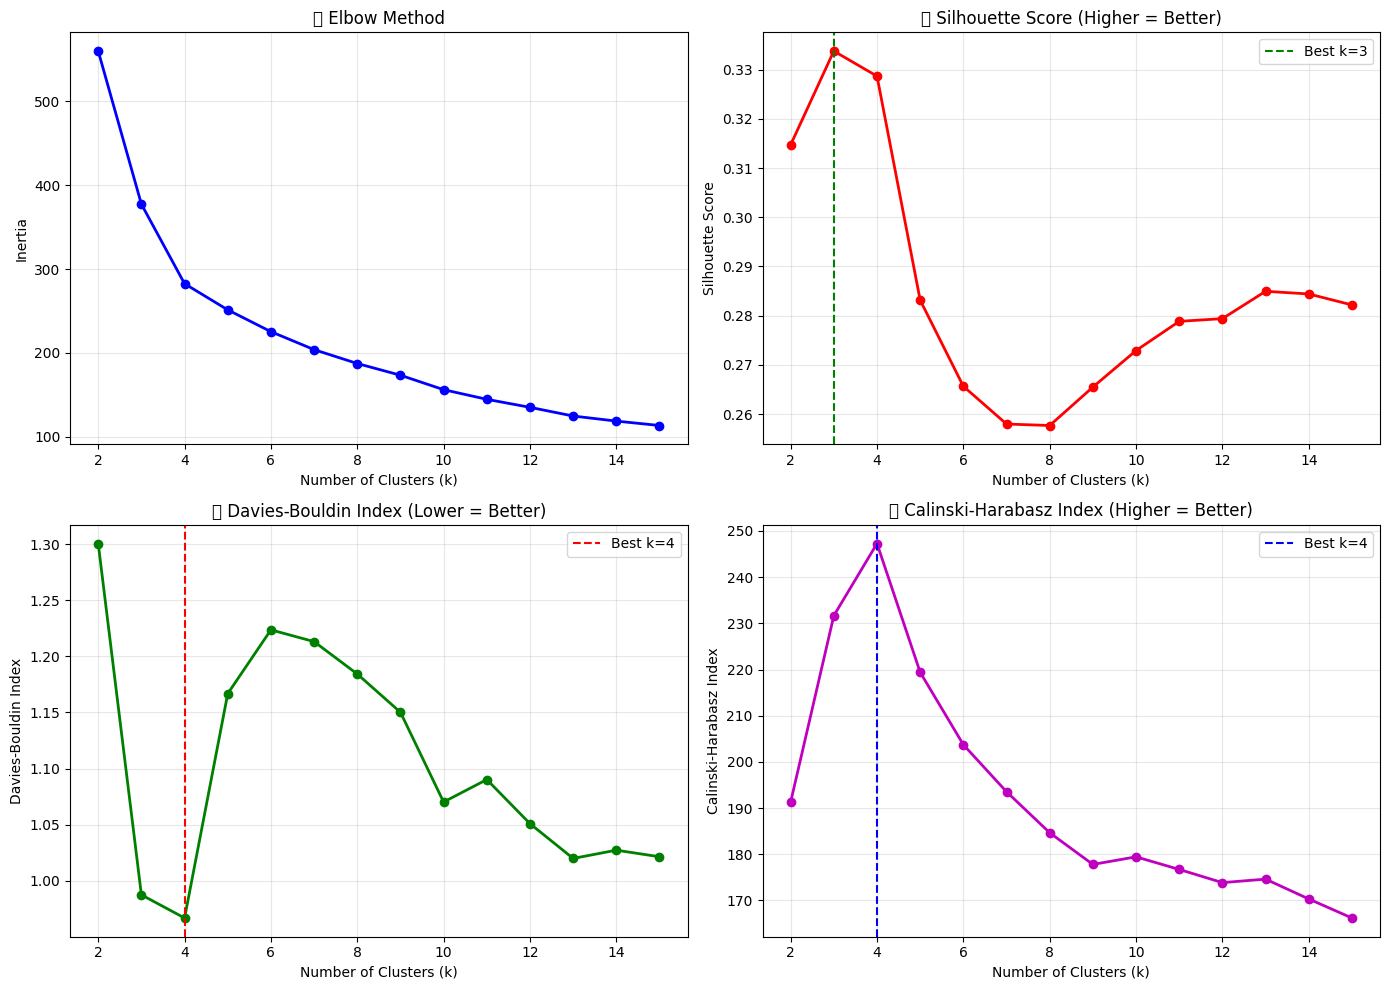


✅ Best k by different metrics:
   Silhouette Score: k=3 (score=0.3338)
   Davies-Bouldin: k=4 (score=0.9670)
   Calinski-Harabasz: k=4 (score=247.27)


In [32]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Elbow Method
axes[0, 0].plot(metrics['k'], metrics['inertia'], 'bo-', linewidth=2)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('📈 Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Silhouette Score (higher is better)
best_k_sil = metrics['k'][np.argmax(metrics['silhouette'])]
axes[0, 1].plot(metrics['k'], metrics['silhouette'], 'ro-', linewidth=2)
axes[0, 1].axvline(x=best_k_sil, color='g', linestyle='--', label=f'Best k={best_k_sil}')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('📊 Silhouette Score (Higher = Better)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Davies-Bouldin Index (lower is better)
best_k_db = metrics['k'][np.argmin(metrics['davies_bouldin'])]
axes[1, 0].plot(metrics['k'], metrics['davies_bouldin'], 'go-', linewidth=2)
axes[1, 0].axvline(x=best_k_db, color='r', linestyle='--', label=f'Best k={best_k_db}')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('📉 Davies-Bouldin Index (Lower = Better)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Calinski-Harabasz Index (higher is better)
best_k_ch = metrics['k'][np.argmax(metrics['calinski_harabasz'])]
axes[1, 1].plot(metrics['k'], metrics['calinski_harabasz'], 'mo-', linewidth=2)
axes[1, 1].axvline(x=best_k_ch, color='b', linestyle='--', label=f'Best k={best_k_ch}')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Index')
axes[1, 1].set_title('📊 Calinski-Harabasz Index (Higher = Better)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/optimal_k_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Best k by different metrics:")
print(f"   Silhouette Score: k={best_k_sil} (score={max(metrics['silhouette']):.4f})")
print(f"   Davies-Bouldin: k={best_k_db} (score={min(metrics['davies_bouldin']):.4f})")
print(f"   Calinski-Harabasz: k={best_k_ch} (score={max(metrics['calinski_harabasz']):.2f})")

In [33]:
# Select optimal k (using Silhouette Score as primary metric)
OPTIMAL_K = best_k_sil

print(f"\n🎯 SELECTED OPTIMAL K: {OPTIMAL_K}")
print("=" * 60)
print(f"Based on Silhouette Score (most reliable for clustering quality)")
print(f"\nMetrics at k={OPTIMAL_K}:")
idx = OPTIMAL_K - 2  # Adjust for 0-indexing
print(f"   Inertia: {metrics['inertia'][idx]:.2f}")
print(f"   Silhouette Score: {metrics['silhouette'][idx]:.4f}")
print(f"   Davies-Bouldin Index: {metrics['davies_bouldin'][idx]:.4f}")
print(f"   Calinski-Harabasz Index: {metrics['calinski_harabasz'][idx]:.2f}")


🎯 SELECTED OPTIMAL K: 3
Based on Silhouette Score (most reliable for clustering quality)

Metrics at k=3:
   Inertia: 377.32
   Silhouette Score: 0.3338
   Davies-Bouldin Index: 0.9876
   Calinski-Harabasz Index: 231.66


## 4. Train Final K-Means Model

In [34]:
# Train final model
print("🚀 TRAINING FINAL MODEL")
print("=" * 60)

final_model = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=42,
    n_init=20,  # More initializations for better convergence
    max_iter=500,
    verbose=0
)

# Fit model
train_labels = final_model.fit_predict(X_train_weighted)

# Add cluster labels to dataframe
df_train['cluster'] = train_labels

# Calculate final metrics
train_silhouette = silhouette_score(X_train_weighted, train_labels)
train_davies_bouldin = davies_bouldin_score(X_train_weighted, train_labels)
train_calinski = calinski_harabasz_score(X_train_weighted, train_labels)

print(f"\n✅ MODEL TRAINING COMPLETE")
print("=" * 60)
print(f"Number of clusters: {OPTIMAL_K}")
print(f"Training samples: {len(X_train)}")
print(f"\n📊 Training Metrics:")
print(f"   Inertia: {final_model.inertia_:.2f}")
print(f"   Silhouette Score: {train_silhouette:.4f}")
print(f"   Davies-Bouldin Index: {train_davies_bouldin:.4f}")
print(f"   Calinski-Harabasz Index: {train_calinski:.2f}")
print(f"   Iterations: {final_model.n_iter_}")

🚀 TRAINING FINAL MODEL

✅ MODEL TRAINING COMPLETE
Number of clusters: 3
Training samples: 376

📊 Training Metrics:
   Inertia: 377.17
   Silhouette Score: 0.3362
   Davies-Bouldin Index: 0.9823
   Calinski-Harabasz Index: 231.82
   Iterations: 9



📊 CLUSTER DISTRIBUTION (Train Set)
Cluster 0: 147 customers (39.10%)
Cluster 1:  95 customers (25.27%)
Cluster 2: 134 customers (35.64%)


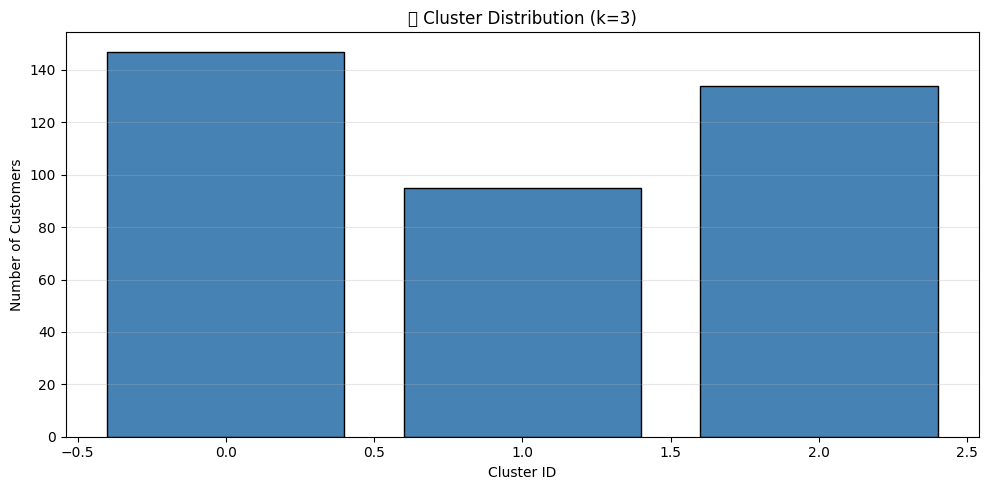

In [35]:
# Cluster distribution
print("\n📊 CLUSTER DISTRIBUTION (Train Set)")
print("=" * 60)
cluster_counts = df_train['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = count / len(df_train) * 100
    print(f"Cluster {cluster_id}: {count:3d} customers ({percentage:5.2f}%)")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')
plt.title(f'📊 Cluster Distribution (k={OPTIMAL_K})')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../data/train_cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Visualize Training Clusters

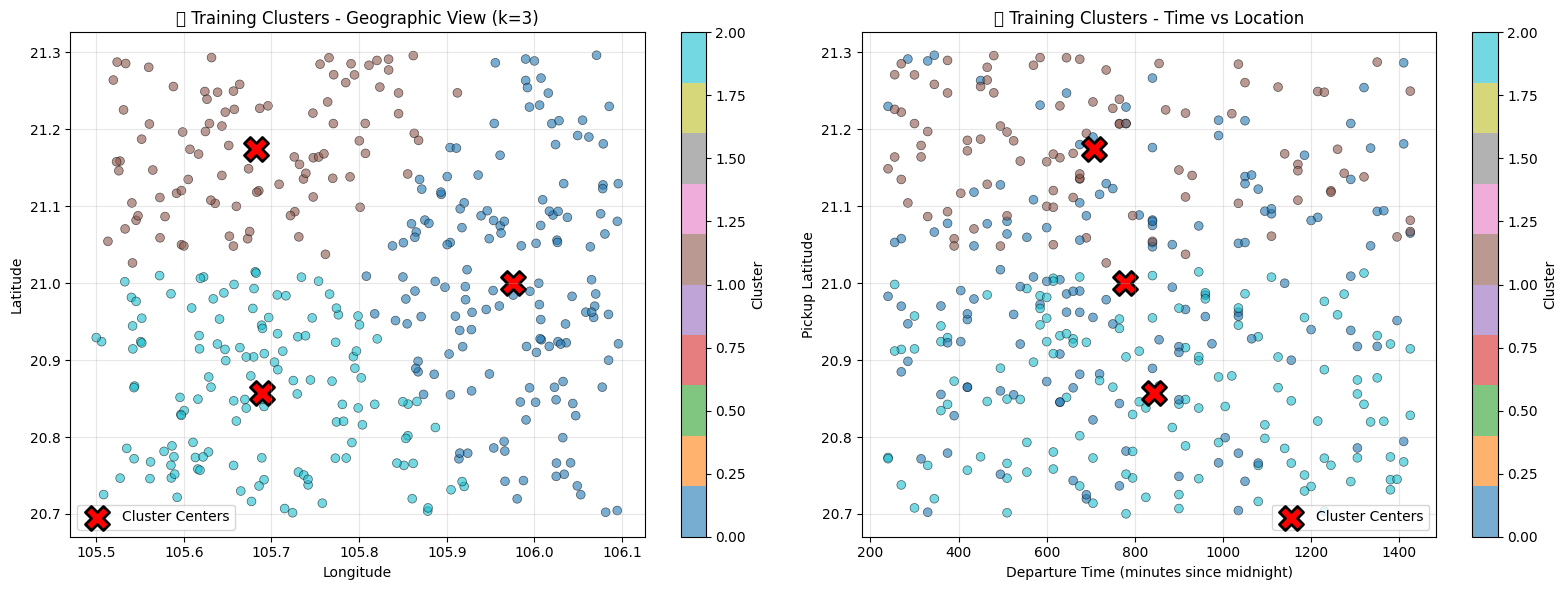

In [36]:
# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Geographic view
scatter1 = axes[0].scatter(
    df_train['pickup_coordinates_lng'],
    df_train['pickup_coordinates_lat'],
    c=df_train['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=40,
    edgecolors='black',
    linewidth=0.5
)

# Plot cluster centers (convert back from weighted space)
centers = final_model.cluster_centers_
# Unweight
centers_unweighted = centers.copy()
centers_unweighted[:, 0] /= COORD_WEIGHT
centers_unweighted[:, 1] /= COORD_WEIGHT
centers_unweighted[:, 2] /= TIME_WEIGHT
# Inverse transform
centers_original = scaler.inverse_transform(centers_unweighted)

axes[0].scatter(
    centers_original[:, 1],  # lng
    centers_original[:, 0],  # lat
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers'
)

axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'📍 Training Clusters - Geographic View (k={OPTIMAL_K})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Time vs Latitude
scatter2 = axes[1].scatter(
    df_train['departure_time_minutes'],
    df_train['pickup_coordinates_lat'],
    c=df_train['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=40,
    edgecolors='black',
    linewidth=0.5
)

axes[1].scatter(
    centers_original[:, 2],  # time
    centers_original[:, 0],  # lat
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers'
)

axes[1].set_xlabel('Departure Time (minutes since midnight)')
axes[1].set_ylabel('Pickup Latitude')
axes[1].set_title(f'⏰ Training Clusters - Time vs Location')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('../data/train_clusters_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Analyze Cluster Characteristics

In [37]:
# Analyze each cluster
print("\n📊 CLUSTER CHARACTERISTICS")
print("=" * 80)

cluster_stats = []

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_train[df_train['cluster'] == cluster_id]
    
    stats = {
        'cluster_id': cluster_id,
        'size': len(cluster_data),
        'avg_lat': cluster_data['pickup_coordinates_lat'].mean(),
        'avg_lng': cluster_data['pickup_coordinates_lng'].mean(),
        'avg_time_min': cluster_data['departure_time_minutes'].mean(),
        'std_lat': cluster_data['pickup_coordinates_lat'].std(),
        'std_lng': cluster_data['pickup_coordinates_lng'].std(),
        'std_time': cluster_data['departure_time_minutes'].std(),
    }
    
    # Convert time to HH:MM
    hours = int(stats['avg_time_min'] // 60)
    minutes = int(stats['avg_time_min'] % 60)
    stats['avg_time_str'] = f"{hours:02d}:{minutes:02d}"
    
    cluster_stats.append(stats)
    
    print(f"\nCluster {cluster_id}:")
    print(f"   Size: {stats['size']} customers")
    print(f"   Average location: ({stats['avg_lat']:.4f}, {stats['avg_lng']:.4f})")
    print(f"   Location spread (std): ({stats['std_lat']:.4f}, {stats['std_lng']:.4f})")
    print(f"   Average departure time: {stats['avg_time_str']}")
    print(f"   Time spread (std): {stats['std_time']:.1f} minutes")

cluster_stats_df = pd.DataFrame(cluster_stats)
cluster_stats_df


📊 CLUSTER CHARACTERISTICS

Cluster 0:
   Size: 147 customers
   Average location: (20.9996, 105.9757)
   Location spread (std): (0.1453, 0.0734)
   Average departure time: 12:57
   Time spread (std): 323.9 minutes

Cluster 1:
   Size: 95 customers
   Average location: (21.1745, 105.6820)
   Location spread (std): (0.0760, 0.1040)
   Average departure time: 11:46
   Time spread (std): 337.5 minutes

Cluster 2:
   Size: 134 customers
   Average location: (20.8570, 105.6887)
   Location spread (std): (0.0921, 0.1038)
   Average departure time: 14:03
   Time spread (std): 337.0 minutes


,cluster_id,size,avg_lat,avg_lng,avg_time_min,std_lat,std_lng,std_time,avg_time_str
0,0,147,20.999645,105.975664,777.142857,0.145308,0.073368,323.921287,12:57
1,1,95,21.174539,105.681982,706.736842,0.076040,0.104022,337.514987,11:46
2,2,134,20.857003,105.688702,843.805970,0.092115,0.103793,336.983623,14:03


## 7. Save Model & Configuration

In [38]:
# Create models directory
import os
MODELS_DIR = '../data/models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Save K-Means model
with open(f'{MODELS_DIR}/kmeans_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save scaler
with open(f'{MODELS_DIR}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save cluster centers in original space
np.save(f'{MODELS_DIR}/cluster_centers.npy', centers_original)

# Save training configuration
train_config = {
    'model_type': 'KMeans',
    'n_clusters': int(OPTIMAL_K),
    'coord_weight': COORD_WEIGHT,
    'time_weight': TIME_WEIGHT,
    'feature_columns': metadata['feature_columns'],
    'random_seed': 42,
    'n_init': 20,
    'max_iter': 500,
    'training_metrics': {
        'inertia': float(final_model.inertia_),
        'silhouette_score': float(train_silhouette),
        'davies_bouldin_index': float(train_davies_bouldin),
        'calinski_harabasz_index': float(train_calinski),
        'n_iterations': int(final_model.n_iter_)
    },
    'train_samples': int(len(X_train)),
    'cluster_distribution': cluster_counts.to_dict(),
    'trained_date': datetime.now().isoformat()
}

with open(f'{MODELS_DIR}/train_config.json', 'w') as f:
    json.dump(train_config, f, indent=2)

# Save cluster statistics
cluster_stats_df.to_csv(f'{MODELS_DIR}/cluster_statistics.csv', index=False)

# Save training data with cluster labels
df_train.to_csv(f'{MODELS_DIR}/train_data_clustered.csv', index=False)

print("\n✅ MODEL & CONFIG SAVED")
print("=" * 60)
print(f"Directory: {MODELS_DIR}/")
print(f"\nFiles created:")
print(f"   - kmeans_model.pkl")
print(f"   - scaler.pkl")
print(f"   - cluster_centers.npy")
print(f"   - train_config.json")
print(f"   - cluster_statistics.csv")
print(f"   - train_data_clustered.csv")


✅ MODEL & CONFIG SAVED
Directory: ../data/models/

Files created:
   - kmeans_model.pkl
   - scaler.pkl
   - cluster_centers.npy
   - train_config.json
   - cluster_statistics.csv
   - train_data_clustered.csv


In [39]:
# Display training config
print("\n📋 TRAINING CONFIGURATION:")
print(json.dumps(train_config, indent=2))


📋 TRAINING CONFIGURATION:
{
  "model_type": "KMeans",
  "n_clusters": 3,
  "coord_weight": 1.0,
  "time_weight": 0.5,
  "feature_columns": [
    "pickup_coordinates_lat",
    "pickup_coordinates_lng",
    "departure_time_minutes"
  ],
  "random_seed": 42,
  "n_init": 20,
  "max_iter": 500,
  "training_metrics": {
    "inertia": 377.17494258296836,
    "silhouette_score": 0.3361919577078005,
    "davies_bouldin_index": 0.9823439640634226,
    "calinski_harabasz_index": 231.81782068951415,
    "n_iterations": 9
  },
  "train_samples": 376,
  "cluster_distribution": {
    "0": 147,
    "1": 95,
    "2": 134
  },
  "trained_date": "2026-01-08T21:26:34.444250"
}


## Summary

✅ **Completed training steps:**
1. Loaded preprocessed training data
2. Applied feature scaling with weights
3. Found optimal k using multiple metrics
4. Trained K-Means model
5. Analyzed cluster characteristics
6. Saved model and configuration

**Training Results:**
- Optimal k: {OPTIMAL_K}
- Silhouette Score: {train_silhouette:.4f}
- Davies-Bouldin Index: {train_davies_bouldin:.4f}

**Next step:** Open `03_model_evaluation.ipynb` to evaluate model on test set